# National Tsing Hua University Robust and Stochastic Portfolio Optimization (Fall 2021)

 - Programming HW 6

In [1]:
# Basic
import cvxpy as cp
import numpy as np
import pandas as pd 
import yfinance as yf 

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

# Black-Litterman Model

In [2]:
start_date = '2020-11-30'
end_date   = '2021-11-30'

# yfinance likes the tickers formatted as a list
tickers   = ['VTI', 'VGK', 'VWO', 'BNDW', '0050.TW']
ticks     = yf.Tickers(tickers)
Stock_DF  = ticks.history(start=start_date, end=end_date).Close
Stock_DF  = Stock_DF.dropna(axis=0)
Stock_DF  = Stock_DF[tickers]
Return_DF = Stock_DF.pct_change()[1:]

Stock_DF.head()

[*********************100%***********************]  5 of 5 completed


,VTI,VGK,VWO,BNDW,0050.TW
Date,,,,,
2020-11-30,186.699997,57.720001,47.560001,82.180000,113.300003
2020-12-01,189.070007,59.180000,48.549999,81.809998,114.300003
2020-12-02,189.229996,59.130001,48.529999,81.739998,115.400002
2020-12-03,189.610001,59.310001,49.009998,81.879997,115.400002
2020-12-04,191.509995,59.840000,49.340000,81.809998,117.300003


In [3]:
u = Return_DF.mean().values
Cov_Matrix = Return_DF.cov()


q = np.array([0.015,0.005,0.01])

p1 = [0,0,-1,0,1]
p2 = [0,-0.5,0,0,1]
p3 = [0,-0.5,0,0,1]

p = np.matrix([p1,p2,p3])

Identity_Matrix = np.identity(u.shape[0])


y          = np.hstack((u,q)).reshape(-1,1)
M          = np.vstack((Identity_Matrix,p))
error_term = np.random.normal(0, 1, size=(M.shape[0], 1))



zeros_1 = np.zeros((q.shape[0],Cov_Matrix.shape[0]))
zeros_2 = zeros_1.T

Investor_view_cov = (Return_DF @ p.T).cov()

v1 = np.hstack((np.linalg.inv(Cov_Matrix),zeros_2))
v2 = np.hstack((zeros_1 , np.linalg.inv(Investor_view_cov) ))
V  = np.vstack((v1,v2))


print("Y:\n", y)
print("M:\n", M)
print("V:\n",V)
print("error_term:\n", error_term)

Y:
 [[ 0.00106047]
 [ 0.00060372]
 [ 0.00019673]
 [-0.00011982]
 [ 0.00090683]
 [ 0.015     ]
 [ 0.005     ]
 [ 0.01      ]]
M:
 [[ 1.   0.   0.   0.   0. ]
 [ 0.   1.   0.   0.   0. ]
 [ 0.   0.   1.   0.   0. ]
 [ 0.   0.   0.   1.   0. ]
 [ 0.   0.   0.   0.   1. ]
 [ 0.   0.  -1.   0.   1. ]
 [ 0.  -0.5  0.   0.   1. ]
 [ 0.  -0.5  0.   0.   1. ]]
V:
 [[ 4.10523476e+04 -2.40297724e+04 -6.73138743e+03 -1.95536413e+04
   1.04547267e+03  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.40297724e+04  3.81289230e+04 -8.33890797e+03  1.39743936e+04
  -4.52019231e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-6.73138743e+03 -8.33890797e+03  1.69303674e+04  2.88333032e+03
  -3.72144611e+03  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.95536413e+04  1.39743936e+04  2.88333032e+03  2.54918783e+05
   4.47814002e+03  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.04547267e+03 -4.52019231e+02 -3.72144611e+03  4.47814002e+03
   8.52548912e+03  0.00000000e+00  0.0000000

In [4]:
Posterior_U = np.linalg.inv(M.T @ V @ M) @ M.T @ V @ y
Posterior_U = np.array(Posterior_U).reshape(u.shape)
Posterior_U 

array([-0.00132671, -0.00171269, -0.00583389, -0.00012675,  0.00169854])

In [5]:
class CVX_Shortfall_Risk_Optimization():
    
    def __init__(self,u,cov,shortfall_risk,chance):

        self.u              = u 
        self.cov            = cov 
        self.chance         = chance 
        self.params         = cp.Variable((cov.shape[1],1))
        self.shortfall_risk = shortfall_risk / 252

    def constraint_1(self,params):
        
        return  [ cp.sum(params) <= 2 ]  # Allow leverage 
    
    def constraint_2(self,params):

        bound = [ cp.abs(params[i]) <= 2 for i in range(self.cov.shape[1])] # weights Bound Constriants

        return bound 
    
    def constraint_3(self,params):
        
        chance_paramter = np.sqrt(self.chance/(1-self.chance))
        left_norm2      = np.sqrt(np.abs(self.cov)) @ params  * chance_paramter        
        right           = self.u.T @  params  - self.shortfall_risk

        return [ cp.SOC(right , left_norm2) ]

    def Optimize(self):

        constraints = []
        constraints += self.constraint_1(self.params) 
        constraints += self.constraint_2(self.params) 
        constraints += self.constraint_3(self.params) 
        
        Objective_Function = self.u.T @ self.params  - (1/2) * cp.quad_form(self.params ,self.cov) 

        prob  = cp.Problem( cp.Maximize(Objective_Function) , constraints )
        
        return prob , self.params

Max F(x) :  0.015528474345545277
Total Weight :  -0.40138671062555487


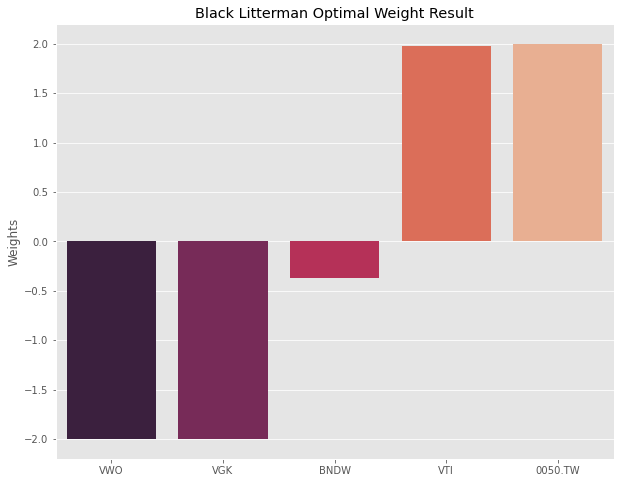

In [6]:
Black_Litterman_Model                         = CVX_Shortfall_Risk_Optimization(u=Posterior_U ,cov=Cov_Matrix.values,shortfall_risk=0.01,chance=0.5)
Black_Litterman_Result,Black_Litterman_Params = Black_Litterman_Model.Optimize()

print("Max F(x) : "      , Black_Litterman_Result.solve()                     )
print("Total Weight : "  , np.sum(Black_Litterman_Params.value)               )
Weight_result = pd.DataFrame(Black_Litterman_Params.value, columns=['Weights'],index=tickers ).sort_values(by='Weights')

# Figure
fig = plt.figure(figsize=(10,8))
ax  = sns.barplot(x=Weight_result.index,y=Weight_result.Weights,palette="rocket").set(title='Black Litterman Optimal Weight Result')
plt.show()

Max F(x) :  0.00256538061763633
Total Weight :  -0.9846193729065466


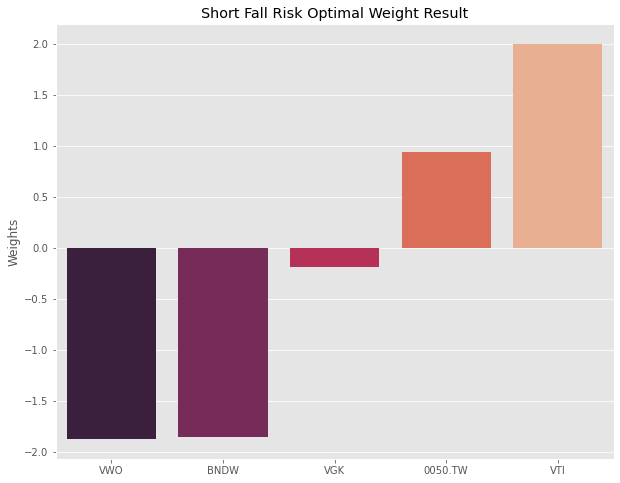

In [7]:
Short_Fall_Risk_Model                         = CVX_Shortfall_Risk_Optimization(u=u ,cov=Cov_Matrix.values,shortfall_risk=0.01,chance=0.2)
Short_Fall_Risk_Result,Short_Fall_Risk_Params = Short_Fall_Risk_Model.Optimize()

print("Max F(x) : "      , Short_Fall_Risk_Result.solve()                     )
print("Total Weight : "  , np.sum(Short_Fall_Risk_Params.value)               )
Weight_result = pd.DataFrame(Short_Fall_Risk_Params.value , columns=['Weights'],index=tickers ).sort_values(by='Weights')

# Figure
fig = plt.figure(figsize=(10,8))
ax  = sns.barplot(x=Weight_result.index,y=Weight_result.Weights,palette="rocket").set(title='Short Fall Risk Optimal Weight Result')
plt.show()

# Principle Component for Factors Selection

In [8]:
start_date = '2020-11-30'
end_date   = '2021-11-30'

# yfinance likes the tickers formatted as a list
tickers   = ['VTI', 'VGK', 'VWO', 'BNDW']
ticks     = yf.Tickers(tickers)
Stock_DF  = ticks.history(start=start_date, end=end_date).Close
Stock_DF  = Stock_DF.dropna(axis=0)
Stock_DF  = Stock_DF[tickers]
Return_DF = Stock_DF.pct_change()[1:]

Return_DF.head()

[*********************100%***********************]  4 of 4 completed


,VTI,VGK,VWO,BNDW
Date,,,,
2020-12-01,0.012694,0.025295,0.020816,-0.004502
2020-12-02,0.000846,-0.000845,-0.000412,-0.000856
2020-12-03,0.002008,0.003044,0.009891,0.001713
2020-12-04,0.010021,0.008936,0.006733,-0.000855
2020-12-07,-0.001097,-0.005849,0.000000,0.001711


(i) Estimate the covariance matrix Σ

In [9]:
Return_DF.cov() 

,VTI,VGK,VWO,BNDW
VTI,0.000064,0.000052,5.558707e-05,1.092734e-06
VGK,0.000052,0.000075,6.282627e-05,-1.603690e-06
VWO,0.000056,0.000063,1.206471e-04,-8.386560e-07
BNDW,0.000001,-0.000002,-8.386560e-07,3.984623e-06


(ii) Consider Market return

In [33]:
Marekt_Return = Return_DF.sum(axis=1).reset_index(name='Market Return')
Marekt_Return

,Date,Market Return
0,2020-12-01,0.054302
1,2020-12-02,-0.001266
2,2020-12-03,0.016656
3,2020-12-04,0.024835
4,2020-12-07,-0.005234
...,...,...
246,2021-11-22,-0.026851
247,2021-11-23,-0.007301
248,2021-11-24,-0.001966
249,2021-11-26,-0.068917


The function LA.eigh lists the eigenvalues from small to large in $D$ (we should reverse it and see the high to low)

and P represent the eigenvector in the matrix of shape (d*d)

In [58]:
from numpy import linalg as LA

D , P = LA.eigh(Return_DF.cov())
print('Bigest eigenvalues     : '  , D[-1]   )
print('Correspond eigenvector : '  , P[:,-1] )

Bigest eigenvalues     :  0.0002050725631534857
Correspond eigenvector :  [-0.47172378 -0.52974912 -0.70485557  0.00460105]


In [59]:
pd.DataFrame(P @ np.diag(D) @ P.T,columns=Return_DF.cov().columns,index=Return_DF.cov().index)

,VTI,VGK,VWO,BNDW
VTI,0.000064,0.000052,5.558707e-05,1.092734e-06
VGK,0.000052,0.000075,6.282627e-05,-1.603690e-06
VWO,0.000056,0.000063,1.206471e-04,-8.386560e-07
BNDW,0.000001,-0.000002,-8.386560e-07,3.984623e-06


In [60]:
Return_DF.cov()

,VTI,VGK,VWO,BNDW
VTI,0.000064,0.000052,5.558707e-05,1.092734e-06
VGK,0.000052,0.000075,6.282627e-05,-1.603690e-06
VWO,0.000056,0.000063,1.206471e-04,-8.386560e-07
BNDW,0.000001,-0.000002,-8.386560e-07,3.984623e-06


In [77]:
factor_returns = Return_DF.values @ P[:,-1].T * -1  # (conduct dimension reduction)
factor_returns = pd.DataFrame(columns=["factor 1"]  ,
                              index=Return_DF.index ,
                              data=factor_returns)

factor_returns

,factor 1
Date,
2020-12-01,0.034081
2020-12-02,-0.000335
2020-12-03,0.009524
2020-12-04,0.014211
2020-12-07,-0.003624
...,...
2021-11-22,-0.013824
2021-11-23,-0.000995
2021-11-24,-0.002625


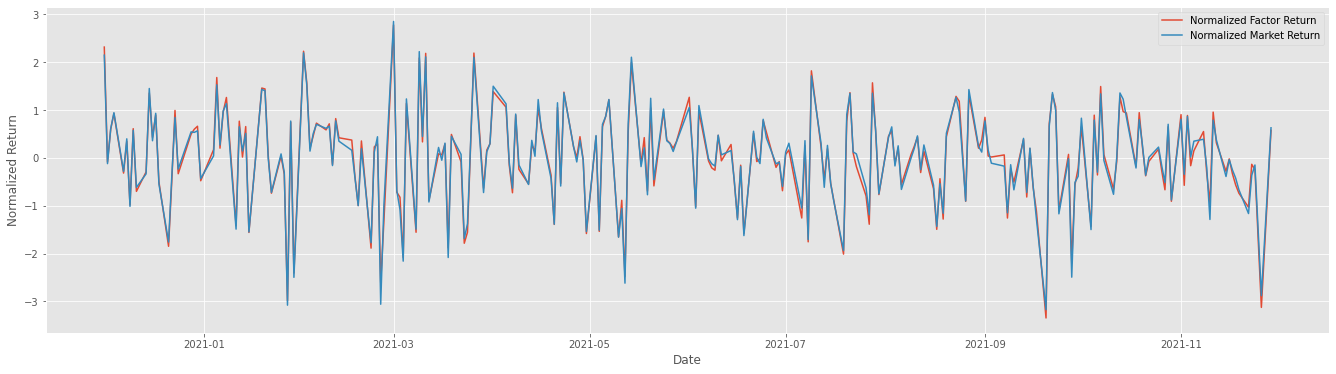

In [80]:
fig , ax = plt.subplots(figsize=(23,6))
ax.plot(factor_returns.index,(factor_returns['factor 1']-factor_returns['factor 1'].mean())/factor_returns['factor 1'].std(),label='Normalized Factor Return')
ax.plot(Marekt_Return['Date'],(Marekt_Return['Market Return']-Marekt_Return['Market Return'].mean())/Marekt_Return['Market Return'].std(),label='Normalized Market Return')
ax.set_ylabel('Normalized Return')
ax.set_xlabel('Date')
ax.legend()
plt.show()